In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mne 
warnings.simplefilter(action='ignore', category=FutureWarning)

eeg_file = '/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/src/EEG.machinelearing_data_BRMH.csv'  
df = pd.read_csv(eeg_file)

DATA CLEANING AND INITIAL EXPLORATION

In [2]:
# What kind of information are we dealing with? let's get some intuition about the participants.

from src.data_visualization import visualize_non_eeg_data as visualize_non_eeg_data
visualize_non_eeg_data(df)


 Dataset Overview (Categorical Columns Only)
--------------------------------------------------
Categorical Data shape: (945, 8)

Column Names and Data Types:
no.                    int64
sex                   object
age                  float64
eeg.date              object
education            float64
IQ                   float64
main.disorder         object
specific.disorder     object
dtype: object

Missing Values:
no.                   0
sex                   0
age                   0
eeg.date              0
education            15
IQ                   13
main.disorder         0
specific.disorder     0
dtype: int64

Descriptive Statistics:
               no.  sex         age   eeg.date   education          IQ  \
count   945.000000  945  945.000000        945  930.000000  932.000000   
unique         NaN    2         NaN        722         NaN         NaN   
top            NaN    M         NaN  2018.7.17         NaN         NaN   
freq           NaN  601         NaN          5     

In [3]:
# We can see there are some missing values in the education and the IQ columns.
# Since there are 15 and 13 NaNs, numbers which are negligible to the 945 rows, we will fill each of the missing values with the average of the column.
from src.data_cleaning import fill_NaNs as fill_NaNs
cleaned_df = fill_NaNs(df,'education')
cleaned_df = fill_NaNs(df, 'IQ')

In [4]:
# Now let's look at the eeg part of the dataframe.
from src.data_visualization import visualize_eeg_data as visualize_eeg_data
visualize_eeg_data(df)


 Dataset Overview (EEG Columns Only)
--------------------------------------------------
EEG Data shape: (945, 1141)

First 5 rows (electrode columns only):
   AB.A.delta.a.FP1  AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  \
0         35.998557         21.717375        21.518280        26.825048   
1         13.425118         11.002916        11.942516        15.272216   
2         29.941780         27.544684        17.150159        23.608960   
3         21.496226         21.846832        17.364316        13.833701   
4         37.775667         33.607679        21.865556        21.771413   

   AB.A.delta.e.Fz  AB.A.delta.f.F4  AB.A.delta.g.F8  AB.A.delta.h.T3  \
0        26.611516        25.732649        16.563408        29.891368   
1        14.151570        12.456034         8.436832         9.975238   
2        27.087811        13.541237        16.523963        12.775574   
3        14.100954        13.100939        14.613650         8.063191   
4        22.854536        2

In [5]:
# Check that the df includes no NaNs.
from src.data_cleaning import check_missing_electrode_values as check_missing_electrode_values
check_missing_electrode_values(df)

# We've found that column 122 is full of NaNs, hence it doesn't contain any useful data. Let's delete the column.
cleaned_df = cleaned_df.dropna(axis=1, how='all')


Missing values in the following electrode columns:
Unnamed: 122    945
dtype: int64


In [6]:
# Next, we'll remove any duplicate rows.
cleaned_df = cleaned_df.drop_duplicates()

# Standarize all of the categorical columns in df (by converting all text to lowercase and stripping any leading/trailing spaces).
from src.data_cleaning import standardize_categorical_columns as standardize_categorical_columns
cleaned_df = standardize_categorical_columns(cleaned_df)

# Check for outliers in the categorical columns. 
from src.data_cleaning import check_for_categorical_outliers as check_for_categorical_outliers
check_for_categorical_outliers(cleaned_df)


 No rare categories detected in categorical columns.


In [7]:
# Reformat the electrode columns from prefix.band.type.channel to band.channel.
from src.data_cleaning import reformat_electrode_columns as reformat_electrode_columns
# Assuming df is your DataFrame
cleaned_df = reformat_electrode_columns(cleaned_df)
print(cleaned_df.head())

   no. sex   age    eeg.date  education          IQ       main.disorder  \
0    1   m  57.0   2012.8.30   13.43871  101.580472  addictive disorder   
1    2   m  37.0    2012.9.6    6.00000  120.000000  addictive disorder   
2    3   m  32.0   2012.9.10   16.00000  113.000000  addictive disorder   
3    4   m  35.0   2012.10.8   18.00000  126.000000  addictive disorder   
4    5   m  36.0  2012.10.18   16.00000  112.000000  addictive disorder   

      specific.disorder  delta.FP1  delta.FP2  ...   gamma.Pz   gamma.Pz  \
0  alcohol use disorder  35.998557  21.717375  ...  55.989192  16.739679   
1  alcohol use disorder  13.425118  11.002916  ...  45.595619  17.510824   
2  alcohol use disorder  29.941780  27.544684  ...  99.475453  70.654171   
3  alcohol use disorder  21.496226  21.846832  ...  59.986561  63.822201   
4  alcohol use disorder  37.775667  33.607679  ...  61.462720  59.166097   

    gamma.Pz   gamma.Pz   gamma.P4   gamma.P4   gamma.P4   gamma.T6  \
0  23.452271  45.6788

In [8]:
# There aren't any categorical outliers in the categorical columns.
# We will leave all of the values in the eeg data columns because we don't wish to modify it. 

# Update the original dataframe, after the cleaning.
df = cleaned_df

DATA ANALYSIS

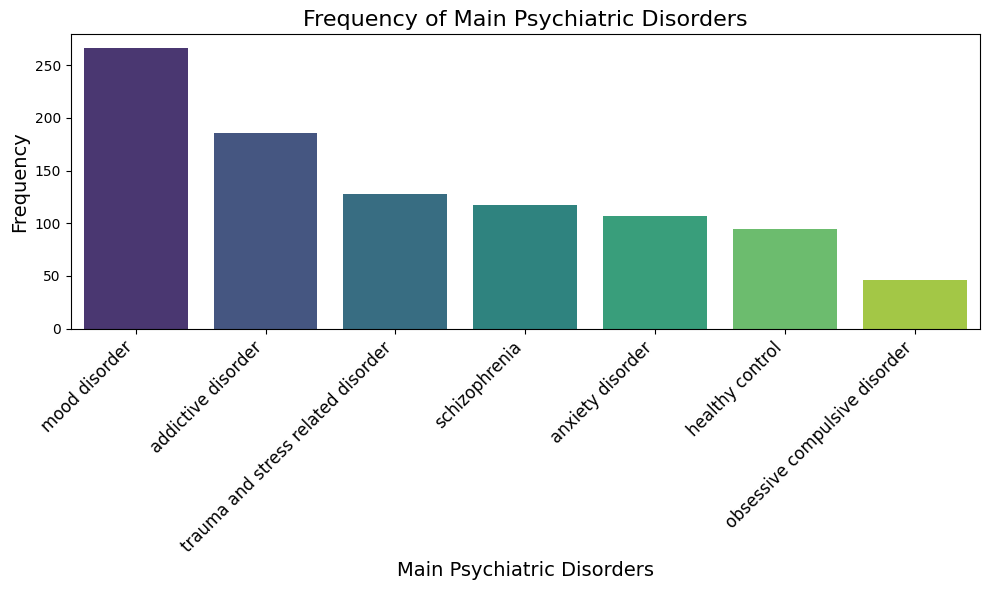

In [9]:
# Our main question is: can we predict a patient's main psychiatric disoder based on their EEG data?
# Let's start by checking the distribution of the main psychiatric disorder column.
from src.data_visualization import visualize_main_psychiatric_disorders as visualize_main_psychiatric_disorders
visualize_main_psychiatric_disorders(df)

In [10]:
# Let's create coordinates for each electrode. 
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}
channels = pd.DataFrame(chs).transpose()
channels

,0,1
FP1,-0.030,0.080
FP2,0.030,0.080
F7,-0.073,0.047
F3,-0.040,0.041
Fz,0.000,0.038
F4,0.040,0.041
F8,0.073,0.047
T3,-0.085,0.000
C3,-0.045,0.000
Cz,0.000,0.000


In [ ]:
# And convert them to 3d coordinates because MNE requires it. 
for key in chs.keys():
    chs[key]+=[0]
chs

{'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}

/var/folders/vk/_vzs395j5h79c_b2kct3ggyc0000gn/T/ipykernel_1662/1805351154.py:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mont.plot()


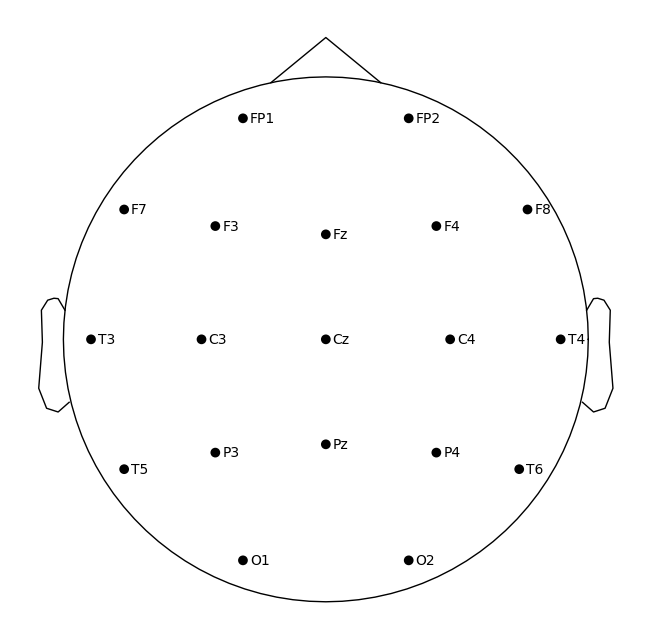

In [12]:
# We will use the MNE Library to plot the electrodes on the head. 
mont = mne.channels.make_dig_montage(chs)
mont.plot()
plt.show()

In [13]:
from src.data_analysis import compute_mean_by_disorder as compute_mean_by_disorder

# Define the frequency bands of interest
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']

# Compute the mean values for each disorder, frequency band, and electrode
combined_output = compute_mean_by_disorder(df, frequency_bands)

# Drop the 'gamma.date' and 'gamma.disorder' columns from the DataFrame
combined_output = combined_output.drop(columns=['gamma.date', 'gamma.disorder'], errors='ignore')

# Display the result
combined_output



,delta.,delta.C3,delta.C4,delta.Cz,delta.F3,delta.F4,delta.F7,delta.F8,delta.FP1,delta.FP2,...,gamma.Fz,gamma.O1,gamma.O2,gamma.P3,gamma.P4,gamma.Pz,gamma.T3,gamma.T4,gamma.T5,gamma.T6
addictive disorder,34.271525,41.855801,39.982079,42.805221,39.586280,37.139200,26.919244,24.687648,34.366379,32.205044,...,46.702849,30.126734,3.143956,49.347496,46.921243,50.390086,35.364920,34.919777,43.052707,36.324592
trauma and stress related disorder,32.251346,39.543848,38.863330,40.915453,38.326584,36.047623,24.006859,23.371300,31.637244,28.404059,...,44.343961,30.549950,3.363356,48.116356,45.689227,49.544871,29.763177,33.868116,40.247326,34.882973
mood disorder,34.243856,42.175944,41.490846,43.352027,39.272461,38.158007,25.923506,26.528766,33.698255,31.223018,...,45.277442,30.191086,3.615276,49.312191,47.226844,50.417250,29.613774,34.784514,41.343931,36.404286
healthy control,36.256779,43.656112,42.776333,45.255986,40.812987,39.729077,28.552845,26.960728,37.299743,33.328864,...,44.179418,28.599444,2.990976,47.856301,47.519278,50.149381,29.746616,33.014092,42.427344,35.882918
obsessive compulsive disorder,37.291317,45.046433,43.874641,45.781199,42.058904,40.613073,30.711470,29.341670,36.700486,32.788316,...,45.042840,33.178846,3.304698,52.595678,49.479117,53.817829,33.420611,34.962371,44.761939,38.791074
schizophrenia,34.309058,41.801922,41.407850,43.132230,39.382974,37.911144,26.071572,25.727486,34.458126,31.078411,...,45.031790,30.749539,3.868594,48.578605,45.824569,49.784935,29.950909,34.899329,40.964855,35.518505
anxiety disorder,33.446627,40.465688,40.037289,42.300294,38.639441,37.110460,25.546933,25.712742,32.657338,30.259760,...,43.797359,30.377653,4.143378,48.068480,45.668834,49.188098,29.373962,33.004340,39.285736,34.861370
